In [1]:
# Install dependencies
# !apt-get update
# !apt-get install ffmpeg libsm6 libxext6  -y
!pip install -q smdebug
!pip install -q seaborn
!pip install -q plotly
!pip install -q opencv-python
!pip install -q shap
!pip install -q bokeh
!pip install -q imageio

/usr/bin/sh: apt-get: command not found
/usr/bin/sh: apt-get: command not found
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


# Using SageMaker Neo to Compile a Tensorflow U-Net Model

[SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) makes it easy to compile pre-trained TensorFlow models and build an inference optimized container without the need for any custom model serving or inference code.

<img src="https://paperswithcode.com/media/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png" align="center" style="padding: 8px;width:500px;">

[U-Net](https://paperswithcode.com/method/u-net) is an architecture for semantic segmentation. It's a popular model for biological images including Ultrasound, Microscopy, CT, MRI and more. 

In this example, we will show how deploy a pre-trained U-Net model to a SageMaker Endpoint with Neo compilation using the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk), and then use the models to perform inference requests. We also provide a performance comparison so you can see the benefits of model compilation.

## Setup

First, we need to ensure we have SageMaker Python SDK 1.x and Tensorflow 1.15.x. Then, import necessary Python packages.

In [2]:
!pip install -U --quiet --upgrade "sagemaker"
!pip install -U --quiet "tensorflow==1.15.3"

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
import tarfile
import numpy as np
import sagemaker
import time
from sagemaker.utils import name_from_base

Next, we'll get the IAM execution role and a few other SageMaker specific variables from our notebook environment, so that SageMaker can access resources in your AWS account later in the example.

In [4]:
from sagemaker import get_execution_role
from sagemaker.session import Session

role = get_execution_role()
sess = Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

SageMaker [Neo supports Tensorflow 1.15.x](https://docs.amazonaws.cn/en_us/sagemaker/latest/dg/neo-supported-cloud.html). Check your version of Tensorflow to prevent downstream framework errors.

In [5]:
import tensorflow as tf

print(tf.__version__)  # This notebook runs on TensorFlow 1.15.x or earlier

1.15.3


## Download U-Net Model

The SageMaker Neo TensorFlow Serving Container works with any model stored in TensorFlow's [SavedModel format](https://www.tensorflow.org/guide/saved_model). This could be the output of your own training job or a model trained elsewhere. For this example, we will use a pre-trained version of the U-Net model based on this [repo](https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018).

In [6]:
model_name = "unet_medical"
export_path = "export"
model_archive_name = "unet-medical.tar.gz"
model_archive_url = "https://sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com/{}".format(
    model_archive_name
)

In [7]:
!wget {model_archive_url}

--2021-11-08 14:59:59--  https://sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com/unet-medical.tar.gz
Resolving sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com (sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com)... 52.219.102.66
Connecting to sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com (sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com)|52.219.102.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7217516 (6.9M) [application/x-gzip]
Saving to: ‘unet-medical.tar.gz’

100%[======================================>] 7,217,516   16.0MB/s   in 0.4s   

2021-11-08 14:59:59 (16.0 MB/s) - ‘unet-medical.tar.gz’ saved [7217516/7217516]



The pre-trained model and its artifacts are saved in a compressed tar file (.tar.gz) so unzip first with:

In [8]:
!tar -xvzf unet-medical.tar.gz

._export
export/
export/._.DS_Store
export/.DS_Store
export/._Servo
export/Servo/
export/Servo/._.DS_Store
export/Servo/.DS_Store
export/Servo/._1
export/Servo/1/
export/Servo/1/._.DS_Store
export/Servo/1/.DS_Store
export/Servo/1/._variables
export/Servo/1/variables/
export/Servo/1/._saved_model.pb
export/Servo/1/saved_model.pb
export/Servo/1/variables/._variables.data-00000-of-00001
export/Servo/1/variables/variables.data-00000-of-00001
export/Servo/1/variables/._variables.index
export/Servo/1/variables/variables.index


After downloading the model, we can inspect it using TensorFlow's ``saved_model_cli`` command. In the command output, you should see 

```
MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
...
```

The command output should also show details of the model inputs and outputs.

In [9]:
import os

model_path = os.path.join(export_path, "Servo/1")
!saved_model_cli show --all --dir {model_path}


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 256, 256, 3)
        name: input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['score'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 256, 256, 1)
        name: conv2d_19/Sigmoid:0
  Method name is: tensorflow/serving/predict


Next we need to create a model archive file containing the exported model.

## Upload the model archive file to S3

We now have a suitable model archive ready in our notebook. We need to upload it to S3 before we can create a SageMaker Model that. We'll use the SageMaker Python SDK to handle the upload.

In [10]:
model_data = Session().upload_data(path=model_archive_name, key_prefix="model")
print("model uploaded to: {}".format(model_data))

model uploaded to: s3://sagemaker-us-west-2-230755935769/model/unet-medical.tar.gz


## Create a SageMaker Model and Endpoint

Now that the model archive is in S3, we can create an unoptimized Model and deploy it to an 
Endpoint.

In [11]:
from sagemaker.tensorflow.serving import Model

instance_type = "ml.c4.xlarge"
framework = "TENSORFLOW"
framework_version = "1.15.3"

In [12]:
sm_model = Model(model_data=model_data, framework_version=framework_version, role=role)
uncompiled_predictor = sm_model.deploy(initial_instance_count=1, instance_type=instance_type)

The class sagemaker.tensorflow.serving.Model has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

## Make predictions using the endpoint

The endpoint is now up and running, and ready to handle inference requests. The `deploy` call above returned a `predictor` object. The `predict` method of this object handles sending requests to the endpoint. It also automatically handles JSON serialization of our input arguments, and JSON deserialization of the prediction results.

We'll use this sample image:

<img src="https://sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com/cell-4.png" align="left" style="padding: 8px;">

In [13]:
sample_img_fname = "cell-4.png"
sample_img_url = "https://sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com/{}".format(
    sample_img_fname
)

In [14]:
!wget {sample_img_url}

--2021-11-08 15:03:27--  https://sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com/cell-4.png
Resolving sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com (sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com)... 52.219.102.202
Connecting to sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com (sagemaker-neo-artifacts.s3.us-east-2.amazonaws.com)|52.219.102.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45936 (45K) [image/png]
Saving to: ‘cell-4.png’

100%[======================================>] 45,936      --.-K/s   in 0.05s   

2021-11-08 15:03:28 (948 KB/s) - ‘cell-4.png’ saved [45936/45936]



In [15]:
# read the image file into a tensor (numpy array)
import cv2

image = cv2.imread(sample_img_fname)
original_shape = image.shape

In [16]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray", interpolation="none")
plt.show()

<Figure size 640x480 with 1 Axes>

In [17]:
image = np.resize(image, (256, 256, 3))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.asarray(image)
image = np.expand_dims(image, axis=0)

In [18]:
start_time = time.time()

# get a prediction from the endpoint
# the image input is automatically converted to a JSON request.
# the JSON response from the endpoint is returned as a python dict
result = uncompiled_predictor.predict(image)
print("Prediction took %.2f seconds" % (time.time() - start_time))

Prediction took 1.16 seconds


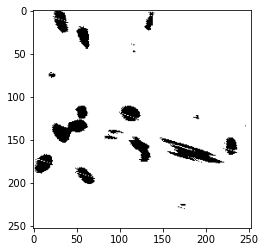

In [19]:
# show the predicted segmentation image

cutoff = 0.4
segmentation_img = np.squeeze(np.asarray(result["predictions"])) > cutoff
segmentation_img = segmentation_img.astype(np.uint8)
segmentation_img = np.resize(segmentation_img, (original_shape[0], original_shape[1]))
plt.imshow(segmentation_img, "gray")
plt.show()

## Uncompiled Predictor Performance

In [20]:
shape_input = np.random.rand(1, 256, 256, 3)
uncompiled_results = []

for _ in range(100):
    start = time.time()
    uncompiled_predictor.predict(image)
    uncompiled_results.append((time.time() - start) * 1000)

print("\nPredictions for un-compiled model: \n")
print("\nP95: " + str(np.percentile(uncompiled_results, 95)) + " ms\n")
print("P90: " + str(np.percentile(uncompiled_results, 90)) + " ms\n")
print("P50: " + str(np.percentile(uncompiled_results, 50)) + " ms\n")
print("Average: " + str(np.average(uncompiled_results)) + " ms\n")


Predictions for un-compiled model: 


P95: 538.2373929023742 ms

P90: 505.3648710250855 ms

P50: 397.51875400543213 ms

Average: 413.6315083503723 ms



## Compile model using SageMaker Neo

In [23]:
# Replace the value of data_shape below and
# specify the name & shape of the expected inputs for your trained model in JSON
# Note that -1 is replaced with 1 for the batch size placeholder
data_shape = {"inputs": [1, 224, 224, 3]}

instance_family = "ml_c4"

compilation_job_name = name_from_base("medical-tf-Neo")
# output path for compiled model artifact
compiled_model_path = "s3://{}/{}/output".format(bucket, compilation_job_name)

In [24]:
optimized_estimator = sm_model.compile(
    target_instance_family=instance_family,
    input_shape=data_shape,
    job_name=compilation_job_name,
    role=role,
    framework=framework.lower(),
    framework_version=framework_version,
    output_path=compiled_model_path,
)

?????????????????????????.................................................!

## Create Optimized Endpoint

In [25]:
optimized_predictor = optimized_estimator.deploy(
    initial_instance_count=1, instance_type=instance_type
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

In [26]:
start_time = time.time()

# get a prediction from the endpoint
# the image input is automatically converted to a JSON request.
# the JSON response from the endpoint is returned as a python dict
result = optimized_predictor.predict(image)
print("Prediction took %.2f seconds" % (time.time() - start_time))

Prediction took 0.81 seconds


## Compiled Predictor Performance

In [27]:
compiled_results = []
test_input = {"instances": np.asarray(shape_input).tolist()}
# Warmup inference.
optimized_predictor.predict(image)
# Inferencing 100 times.
for _ in range(100):
    start = time.time()
    optimized_predictor.predict(image)
    compiled_results.append((time.time() - start) * 1000)

print("\nPredictions for compiled model: \n")
print("\nP95: " + str(np.percentile(compiled_results, 95)) + " ms\n")
print("P90: " + str(np.percentile(compiled_results, 90)) + " ms\n")
print("P50: " + str(np.percentile(compiled_results, 50)) + " ms\n")
print("Average: " + str(np.average(compiled_results)) + " ms\n")


Predictions for compiled model: 


P95: 394.85707283020014 ms

P90: 373.90453815460205 ms

P50: 341.60518646240234 ms

Average: 337.3559617996216 ms



## Performance Comparison

Here we compare inference speed up provided by SageMaker Neo. P90 is 90th percentile latency. We add this because it represents the tail of the latency distribution (worst case). More information on latency percentiles [here](https://blog.bramp.net/post/2018/01/16/measuring-percentile-latency/). 

In [28]:
p90 = np.percentile(uncompiled_results, 90) / np.percentile(compiled_results, 90)
p50 = np.percentile(uncompiled_results, 50) / np.percentile(compiled_results, 50)
avg = np.average(uncompiled_results) / np.average(compiled_results)

print("P90 Speedup: %.2f" % p90)
print("P50 Speedup: %.2f" % p50)
print("Average Speedup: %.2f" % avg)

P90 Speedup: 1.35
P50 Speedup: 1.16
Average Speedup: 1.23


## Setup Elastic Inference Endpoint 

In [33]:
predictor_ei = sm_model.deploy(initial_instance_count=1, 
                        instance_type='ml.c4.xlarge',
                            accelerator_type='ml.eia2.medium')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------!

In [34]:
start_time = time.time()

# get a prediction from the endpoint
# the image input is automatically converted to a JSON request.
# the JSON response from the endpoint is returned as a python dict
result = predictor_ei.predict(image)
print("Prediction took %.2f seconds" % (time.time() - start_time))

Prediction took 1.07 seconds


In [37]:
ei_results = []
test_input = {"instances": np.asarray(shape_input).tolist()}
# Warmup inference.
optimized_predictor.predict(image)
# Inferencing 100 times.
for _ in range(100):
    start = time.time()
    predictor_ei.predict(image)
    ei_results.append((time.time() - start) * 1000)

print("\nPredictions for compiled model: \n")
print("\nP95: " + str(np.percentile(ei_results, 95)) + " ms\n")
print("P90: " + str(np.percentile(ei_results, 90)) + " ms\n")
print("P50: " + str(np.percentile(ei_results, 50)) + " ms\n")
print("Average: " + str(np.average(ei_results)) + " ms\n")


Predictions for compiled model: 


P95: 373.9136576652527 ms

P90: 359.7217321395874 ms

P50: 335.57236194610596 ms

Average: 328.0187797546387 ms



### Performance Comparison 

we can compare with increased performance between the vanilla predictor and the one equipped with elastic inference. The design decision could reference to the usage pattern and the price structure of [elastic inference](https://aws.amazon.com/machine-learning/elastic-inference/pricing/). Or plot a graph like what in this [blog](https://aws.amazon.com/blogs/machine-learning/increasing-performance-and-reducing-the-cost-of-mxnet-inference-using-amazon-sagemaker-neo-and-amazon-elastic-inference/) 

In [36]:
p90 = np.percentile(uncompiled_results, 90) / np.percentile(ei_results, 90)
p50 = np.percentile(uncompiled_results, 50) / np.percentile(ei_results, 50)
avg = np.average(uncompiled_results) / np.average(ei_results)

print("P90 Speedup: %.2f" % p90)
print("P50 Speedup: %.2f" % p50)
print("Average Speedup: %.2f" % avg)

P90 Speedup: 1.36
P50 Speedup: 1.14
Average Speedup: 1.23


## Additional Information

## Cleaning up

To avoid incurring charges to your AWS account for the resources used in this tutorial, you need to delete the SageMaker Endpoint.

In [ ]:
uncompiled_predictor.delete_endpoint()

In [ ]:
optimized_predictor.delete_endpoint()